## Work
1. 請比較使用 l1, l1_l2 及不同比例下的訓練結果

In [1]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.regularizers import l1, l2, l1_l2

"""
建立神經網路，並加入 L1 或 L2
"""
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128], l2_ratio=1e-4):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1), 
                                   kernel_regularizer=l1(l2_ratio))(input_layer)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1),
                                   kernel_regularizer=l1(l2_ratio))(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
"""Code Here
設定超參數
"""

## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 256
MOMENTUM = 0.95
L2_EXP = [1e-2, 1e-4, 1e-8, 1e-12]

In [7]:
results = {}
"""Code Here
撰寫你的訓練流程並將結果用 dictionary 紀錄
"""
"""
使用迴圈建立不同的帶不同 L1/L2 的模型並訓練
"""
for regulizer_ratio in L2_EXP:
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Experiment with Regulizer = %.6f" % (regulizer_ratio))
    model = build_mlp(input_shape=x_train.shape[1:], l2_ratio=regulizer_ratio)
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True)
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]
    
    exp_name_tag = "exp-l2-%s" % str(regulizer_ratio)
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}


W0716 15:45:05.025919 4452558272 deprecation_wrapper.py:119] From /anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:95: The name tf.reset_default_graph is deprecated. Please use tf.compat.v1.reset_default_graph instead.

W0716 15:45:05.032435 4452558272 deprecation_wrapper.py:119] From /anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:98: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0716 15:45:05.068946 4452558272 deprecation_wrapper.py:119] From /anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:102: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0716 15:45:05.070535 4452558272 deprecation_wrapper.py:119] From /anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0716 15:45:05.076277 44

Experiment with Regulizer = 0.010000
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
_________________________________________________________________


W0716 15:45:05.326941 4452558272 deprecation_wrapper.py:119] From /anaconda3/lib/python3.7/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0716 15:45:05.685483 4452558272 deprecation.py:323] From /anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 18s 352us/step - loss: 198.6208 - acc: 0.2402 - val_loss: 41.1190 - val_acc: 0.2462
Epoch 2/50
50000/50000 [==============================] - 17s 348us/step - loss: 19.1385 - acc: 0.1171 - val_loss: 7.3199 - val_acc: 0.1000
Epoch 3/50
50000/50000 [==============================] - 15s 303us/step - loss: 4.1280 - acc: 0.0999 - val_loss: 2.6533 - val_acc: 0.1000
Epoch 4/50
50000/50000 [==============================] - 13s 266us/step - loss: 2.4867 - acc: 0.0988 - val_loss: 2.4626 - val_acc: 0.1000
Epoch 5/50
50000/50000 [==============================] - 14s 282us/step - loss: 2.4626 - acc: 0.0969 - val_loss: 2.4626 - val_acc: 0.1000
Epoch 6/50
50000/50000 [==============================] - 14s 276us/step - loss: 2.4626 - acc: 0.0967 - val_loss: 2.4625 - val_acc: 0.1000
Epoch 7/50
50000/50000 [==============================] - 14s 285us/step - loss: 2.4626 - acc: 0.0981 - val_loss

50000/50000 [==============================] - 18s 356us/step - loss: 6.0059 - acc: 0.2761 - val_loss: 5.7995 - val_acc: 0.3501
Epoch 2/50
50000/50000 [==============================] - 14s 289us/step - loss: 5.7160 - acc: 0.3681 - val_loss: 5.6509 - val_acc: 0.3717
Epoch 3/50
50000/50000 [==============================] - 17s 336us/step - loss: 5.5713 - acc: 0.3964 - val_loss: 5.5170 - val_acc: 0.4052
Epoch 4/50
50000/50000 [==============================] - 16s 324us/step - loss: 5.4495 - acc: 0.4195 - val_loss: 5.4002 - val_acc: 0.4260
Epoch 5/50
50000/50000 [==============================] - 17s 335us/step - loss: 5.3386 - acc: 0.4341 - val_loss: 5.3070 - val_acc: 0.4326
Epoch 6/50
50000/50000 [==============================] - 16s 330us/step - loss: 5.2391 - acc: 0.4486 - val_loss: 5.2149 - val_acc: 0.4434
Epoch 7/50
50000/50000 [==============================] - 16s 325us/step - loss: 5.1442 - acc: 0.4582 - val_loss: 5.1402 - val_acc: 0.4450
Epoch 8/50
50000/50000 [==============

50000/50000 [==============================] - 23s 458us/step - loss: 2.0524 - acc: 0.2688 - val_loss: 1.8725 - val_acc: 0.3465
Epoch 2/50
50000/50000 [==============================] - 30s 609us/step - loss: 1.8101 - acc: 0.3679 - val_loss: 1.7586 - val_acc: 0.3838
Epoch 3/50
50000/50000 [==============================] - 26s 519us/step - loss: 1.7281 - acc: 0.3958 - val_loss: 1.6964 - val_acc: 0.4041
Epoch 4/50
50000/50000 [==============================] - 19s 374us/step - loss: 1.6699 - acc: 0.4144 - val_loss: 1.6457 - val_acc: 0.4210
Epoch 5/50
50000/50000 [==============================] - 20s 395us/step - loss: 1.6246 - acc: 0.4315 - val_loss: 1.6201 - val_acc: 0.4283
Epoch 6/50
50000/50000 [==============================] - 24s 487us/step - loss: 1.5840 - acc: 0.4479 - val_loss: 1.5782 - val_acc: 0.4442
Epoch 7/50
50000/50000 [==============================] - 24s 478us/step - loss: 1.5500 - acc: 0.4585 - val_loss: 1.5609 - val_acc: 0.4459
Epoch 8/50
50000/50000 [==============

50000/50000 [==============================] - 16s 310us/step - loss: 2.0377 - acc: 0.2679 - val_loss: 1.8677 - val_acc: 0.3465
Epoch 2/50
50000/50000 [==============================] - 11s 216us/step - loss: 1.8069 - acc: 0.3688 - val_loss: 1.7537 - val_acc: 0.3864
Epoch 3/50
50000/50000 [==============================] - 10s 196us/step - loss: 1.7186 - acc: 0.3983 - val_loss: 1.6826 - val_acc: 0.4123
Epoch 4/50
50000/50000 [==============================] - 11s 229us/step - loss: 1.6570 - acc: 0.4211 - val_loss: 1.6379 - val_acc: 0.4256
Epoch 5/50
50000/50000 [==============================] - 10s 197us/step - loss: 1.6092 - acc: 0.4365 - val_loss: 1.5987 - val_acc: 0.4376
Epoch 6/50
50000/50000 [==============================] - 10s 201us/step - loss: 1.5697 - acc: 0.4521 - val_loss: 1.5733 - val_acc: 0.4426
Epoch 7/50
50000/50000 [==============================] - 10s 205us/step - loss: 1.5355 - acc: 0.4615 - val_loss: 1.5490 - val_acc: 0.4538
Epoch 8/50
50000/50000 [==============

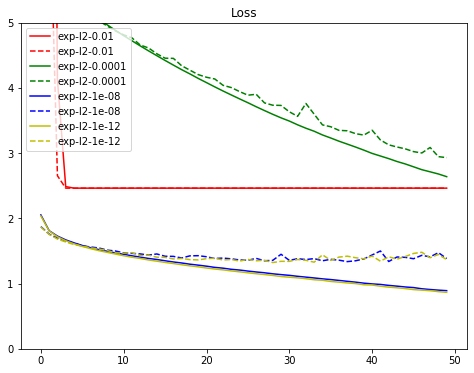

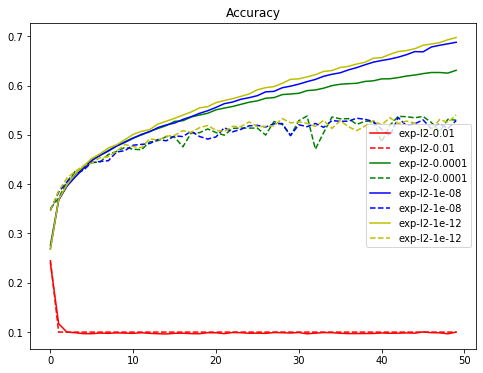

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
"""Code Here
將結果繪出
"""
color_bar = ["r", "g", "b", "y", "m", "k"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()